# FND [Fake News Detection] CLIP Model Analysis

## Environment Setup

In [1]:
# Import Libraries
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import sys
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

## Ensure TensorFlow is not used
import os
os.environ["USE_TF"] = "0"

from transformers import CLIPModel, CLIPTokenizer

# Define data directory
DATA_DIR = "cleaned_data"

# Define file paths
TRAIN_DATA_FILE = os.path.join(DATA_DIR, "train.csv")
VALIDATION_DATA_FILE = os.path.join(DATA_DIR, "validation_5k.csv")
TEST_DATA_FILE = os.path.join(DATA_DIR, "test_5k.csv")

# For reproducability
random_state = 42

# Use CPU/MPS if possible
device = None
if "google.colab" in sys.modules:
    # Running in Colab
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
else:
    # Not in Colab (e.g., Mac)
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print("Using device:", device)

Using device: mps


## Load Data

In [2]:
TRAIN_DATA = pd.read_csv(TRAIN_DATA_FILE)
VALIDATION_DATA = pd.read_csv(VALIDATION_DATA_FILE, index_col = 0)
TEST_DATA = pd.read_csv(TEST_DATA_FILE, index_col = 0)

In [3]:
# Ignore rows in corrupted_indices.txt files
def filter_out_corrupted_rows(split, DF):
    # File with corrupted indices
    if split == "train":
        corrupted_indices_file = f"{split}_corrupted_indices.txt"
    else:
        corrupted_indices_file = f"{split}_5k_corrupted_indices.txt"

    # Store list of corrupted indices
    corrupted_indices = None

    # Get list of corrupted indices
    with open(corrupted_indices_file, "r") as f:
        corrupted_indices = list(int(line.strip()) for line in f if line.strip())

    print(f"Split: {split}, Corrupted Indices: {corrupted_indices}, Length: {len(corrupted_indices)}")

    # Filter out corrupted rows
    DF = DF.drop(index = corrupted_indices)

    return DF

In [4]:
TRAIN_DATA = filter_out_corrupted_rows("train", TRAIN_DATA)
VALIDATION_DATA = filter_out_corrupted_rows("validation", VALIDATION_DATA)
TEST_DATA = filter_out_corrupted_rows("test", TEST_DATA)

Split: train, Corrupted Indices: [2862, 26040, 28337, 18547, 13374, 11288, 31984, 18451, 19000, 22479, 8048, 32075, 22918, 5586, 19345, 12770, 32189, 14628, 9081, 6611, 2927], Length: 21
Split: validation, Corrupted Indices: [6568, 32176], Length: 2
Split: test, Corrupted Indices: [29133, 9437, 26504, 11394], Length: 4


In [5]:
TRAIN_DATA['image_num'] = TRAIN_DATA.index.astype(str).str.zfill(5)
VALIDATION_DATA['image_num'] = VALIDATION_DATA.index.astype(str).str.zfill(5)
TEST_DATA['image_num'] = TEST_DATA.index.astype(str).str.zfill(5)

In [6]:
TRAIN_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
0,this spongebob squarepants branded battery,2019-07-30 20:00:50,i.redd.it,https://preview.redd.it/f39wxxk8yhd31.jpg?widt...,4.0,33,mildlyinteresting,0.95,1,0,0,00000
1,award for careless talk,2011-09-03 17:26:23,i.imgur.com,https://external-preview.redd.it/KgPHCi1u3fY5j...,1.0,14,propagandaposters,1.00,0,1,5,00001
2,four aligned airplanes,2017-11-20 06:05:45,i.redd.it,https://preview.redd.it/88v9axk19phx.jpg?width...,24.0,198,confusing_perspective,0.98,0,2,2,00002
3,columbus discovers the new world,2019-08-28 15:40:17,i.redd.it,https://preview.redd.it/x4wzpd0am7j31.jpg?widt...,5.0,318,fakehistoryporn,0.98,0,2,2,00003
4,feed me drummmmssssssss,2014-05-09 13:23:59,i.imgur.com,https://external-preview.redd.it/yNN57loQnVhLk...,0.0,3,pareidolia,0.62,0,2,2,00004


In [7]:
VALIDATION_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
8637,not as heartwarming as it could have been anth...,2019-09-19 17:48:33,lifestyle.clickhole.com,https://external-preview.redd.it/850kBbKdgMKfz...,0.0,15,theonion,0.86,0,2,1,08637
20669,other discussions,2013-12-09 23:58:43,NaN,http://i.dailymail.co.uk/i/pix/2013/12/09/arti...,NaN,0,psbattle_artwork,NaN,0,2,4,20669
13179,on reflection oc,2015-01-12 17:14:55,i.imgur.com,https://external-preview.redd.it/tiFw8Ggb178E4...,0.0,3,pareidolia,0.67,0,2,2,13179
20565,viet congo setting booby trap,2019-02-27 09:57:07,i.redd.it,https://preview.redd.it/mj81gkh533j21.jpg?widt...,4.0,14,fakehistoryporn,0.80,0,2,2,20565
15504,chief has some happy shoulder armour,2013-02-20 01:00:02,i.imgur.com,https://external-preview.redd.it/kqqIlnAOZxzxA...,0.0,6,pareidolia,1.00,0,2,2,15504


In [8]:
TEST_DATA.head()

,clean_title,created_utc,domain,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label,image_num
19660,young homosexuals gather outside of a nightclu...,2018-07-29 13:59:38,i.redd.it,https://preview.redd.it/16j830998wc11.jpg?widt...,1.0,75,fakehistoryporn,0.92,0,2,2,19660
32879,cara al sol facing the sun a series of posters...,2013-05-20 18:25:00,imgur.com,https://external-preview.redd.it/S_nXt5X8VMqZD...,4.0,19,propagandaposters,0.89,0,1,5,32879
15071,he is awake and rises from the depths,2013-10-13 20:02:17,imgur.com,https://external-preview.redd.it/JetvyFQFm4fYt...,0.0,7,pareidolia,0.99,0,2,2,15071
5198,the reason germany invades france and not spain,2018-09-03 08:22:07,i.redd.it,https://preview.redd.it/ws91cs7lgzj11.png?widt...,0.0,57,fakehistoryporn,0.97,0,2,2,05198
15061,frozen body preserved on mount everest nsfw,2017-09-12 08:10:21,i.redd.it,https://preview.redd.it/zxwc8gq8uelz.jpg?width...,0.0,24,fakehistoryporn,1.00,0,2,2,15061


## Create News Dataset and DataLoader

In [9]:
class RedditDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Fetch text
        text = row['clean_title']

        # Get image number
        image_num = row['image_num']

        # Fetch Image
        img_path = os.path.join(self.image_dir, f"{image_num}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(row['2_way_label'], dtype=torch.long)

        return text, image, label

In [10]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
def collate_fn(batch):
    texts, images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return list(texts), images, labels

In [12]:
train_dataset = RedditDataset(
    df = TRAIN_DATA, 
    image_dir = "train_images",
    transform = train_tfms
)

validation_dataset = RedditDataset(
    df = VALIDATION_DATA, 
    image_dir = "validation_images",
    transform = val_test_tfms
)

test_dataset = RedditDataset(
    df = TEST_DATA, 
    image_dir = "test_images",
    transform = val_test_tfms
)

In [13]:
B = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
    collate_fn=collate_fn
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=False,
    collate_fn=collate_fn
)

## Load CLIP Text and Image Encoders

In [14]:
clip_model_name = "openai/clip-vit-base-patch32"
multimodal_encoder = CLIPModel.from_pretrained(clip_model_name).to(device)
multimodal_encoder_tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)

## Analyze Cosine Similarities

In [15]:
cosine_similarities = []

for batch_idx, (txts, imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)

    # Tokenize Text
    text_encoding = multimodal_encoder_tokenizer(
        txts,
        padding='max_length',
        truncation=True,
        max_length=multimodal_encoder_tokenizer.model_max_length,
        return_tensors="pt"
    ).to(device) # Tokenize text

    fCLIP_T = multimodal_encoder.get_text_features(**text_encoding) # Compute CLIP Text Features [B, 512]
    fCLIP_I = multimodal_encoder.get_image_features(imgs) # Compute CLIP Image Features [B, 512]

    sim = F.cosine_similarity(fCLIP_T, fCLIP_I).tolist() # Compute cosine similarity, Shape: (B, )
    cosine_similarities.extend(sim)

    if (batch_idx + 1) % 25 == 0:
        print(f"Progress: {batch_idx +1} / {len(train_loader)}")

cosine_similarities = np.array(cosine_similarities)
np.save("cosine_similarities.npy", cosine_similarities)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Progress: 25 / 1041
Progress: 50 / 1041
Progress: 75 / 1041
Progress: 100 / 1041
Progress: 125 / 1041
Progress: 150 / 1041
Progress: 175 / 1041
Progress: 200 / 1041
Progress: 225 / 1041
Progress: 250 / 1041
Progress: 275 / 1041
Progress: 300 / 1041
Progress: 325 / 1041
Progress: 350 / 1041
Progress: 375 / 1041
Progress: 400 / 1041
Progress: 425 / 1041
Progress: 450 / 1041
Progress: 475 / 1041
Progress: 500 / 1041
Progress: 525 / 1041
Progress: 550 / 1041
Progress: 575 / 1041
Progress: 600 / 1041
Progress: 625 / 1041
Progress: 650 / 1041
Progress: 675 / 1041
Progress: 700 / 1041
Progress: 725 / 1041
Progress: 750 / 1041
Progress: 775 / 1041
Progress: 800 / 1041
Progress: 825 / 1041
Progress: 850 / 1041
Progress: 875 / 1041
Progress: 900 / 1041
Progress: 925 / 1041
Progress: 950 / 1041
Progress: 975 / 1041
Progress: 1000 / 1041
Progress: 1025 / 1041


## Plot Cosine Similarities

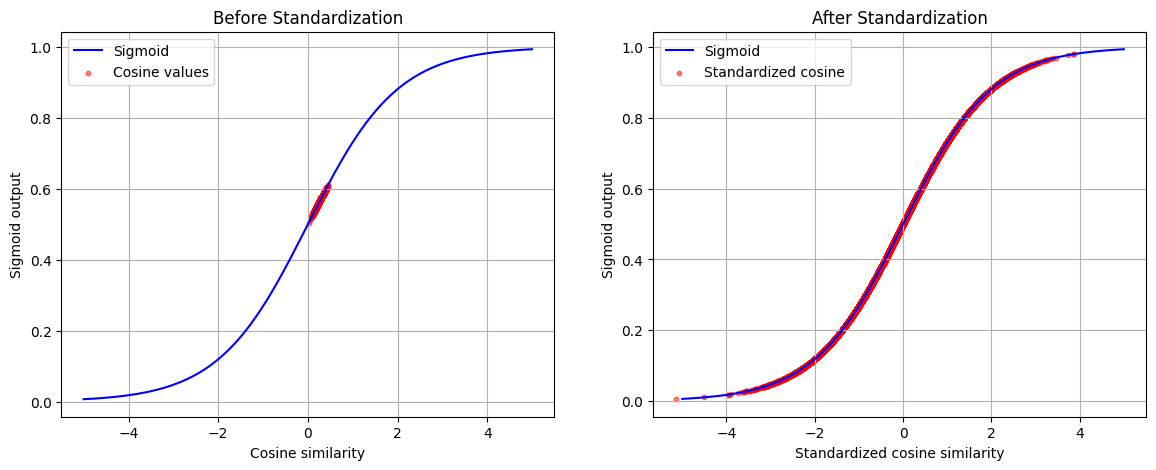

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load cosine similarities
cosine_similarities = np.load("cosine_similarities.npy")

# Standardize
mean = cosine_similarities.mean()
std = cosine_similarities.std()
cosine_standardized = (cosine_similarities - mean) / std

# Sigmoid curve in fixed range [-5, 5]
x = np.linspace(-5, 5, 500)
sigmoid = 1 / (1 + np.exp(-x))
plt.figure(figsize=(14,5))

# Before standardization
plt.subplot(1, 2, 1)
plt.plot(x, sigmoid, color='blue', label='Sigmoid')
plt.scatter(cosine_similarities, 1/(1 + np.exp(-cosine_similarities)), 
            color='red', alpha=0.5, s=10, label='Cosine values')
plt.title("Before Standardization")
plt.xlabel("Cosine similarity")
plt.ylabel("Sigmoid output")
plt.grid(True)
plt.legend()

# After standardization
plt.subplot(1, 2, 2)
plt.plot(x, sigmoid, color='blue', label='Sigmoid')
plt.scatter(cosine_standardized, 1/(1 + np.exp(-cosine_standardized)), 
            color='red', alpha=0.5, s=10, label='Standardized cosine')
plt.title("After Standardization")
plt.xlabel("Standardized cosine similarity")
plt.ylabel("Sigmoid output")
plt.grid(True)
plt.legend()
plt.show()

## Analyze Training Loss Curves

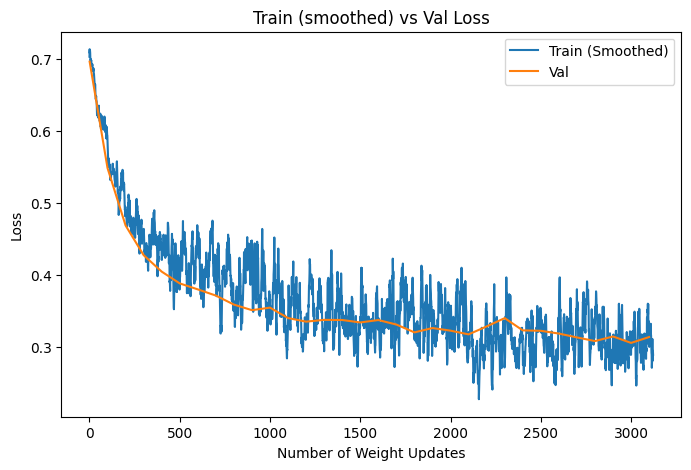

In [23]:
with open("CLIP_metrics.pkl", "rb") as f:
    data = pickle.load(f)

train_losses = np.array(data['train_losses'])
val_losses = np.array(data['val_losses'])

# Smooth only train
train_series  = pd.Series(train_losses)
train_smooth  = train_series.rolling(window=10, min_periods=1).mean()

# Val Steps 
val_every = 100
val_steps = [1] + [i * val_every for i in range(1, len(val_losses))]

plt.figure(figsize=(8,5))
plt.plot(train_smooth, label="Train (Smoothed)")
plt.plot(val_steps, val_losses, label="Val")
plt.xlabel("Number of Weight Updates")
plt.ylabel("Loss")
plt.legend()
plt.title("Train (smoothed) vs Val Loss")
plt.show()
